<a href="https://colab.research.google.com/github/s2ul2/bitamin/blob/main/LSTM_apt_sell_index_prediction_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
import numpy as np

# 항상 같은 결과를 갖기 위해 랜덤 시드 설정
tf.random.set_seed(1)
np.random.seed(1)

# 기존 Vanilla RNN의 한계

In [3]:
Image(url= "https://wikidocs.net/images/page/22888/lstm_image1_ver2.PNG", width=500, height=300)

### [문제1] 기존 Vanilla RNN의 한계를 설명해주세요.
- [답변]  gradient vanishing, gradient Exploding 문제 발생

# Vanilla RNN 내부 열어보기

In [4]:
Image(url="https://wikidocs.net/images/page/22888/vanilla_rnn_ver2.PNG", width=400, height=300)

LSTM에 대해서 이해해보기 전에 Vanilla RNN의 뚜껑을 열어보겠습니다. 위의 그림은 Vanilla RNN의 내부 구조를 보여줍니다. (편향 b는 생략했습니다.) 위의 그림에 편향 b를 그린다면 xt 옆에 tanh로 향하는 또 하나의 입력선을 그리면 됩니다.
$$h_{t} = tanh(W_{x}x_{t} + W_{h}h_{t−1} + b)$$

Vanilla RNN은 xt와 ht−1이라는 두 개의 입력이 각각의 가중치와 곱해져서 메모리 셀의 입력이 됩니다. 그리고 이를 하이퍼볼릭탄젠트 함수의 입력으로 사용하고 이 값은 은닉층의 출력인 은닉 상태가 됩니다.



# LSTM

In [5]:
Image(url="https://wikidocs.net/images/page/22888/vaniila_rnn_and_different_lstm_ver2.PNG")

위의 그림은 LSTM의 전체적인 내부의 모습을 보여줍니다. 전통적인 RNN의 단점을 보완한 RNN의 일종을 LSTM(Long Short-Term Memory)이라고 합니다. LSTM은 은닉층의 메모리 셀에 input gate, forget gate, output gate를 추가하여 불필요한 기억을 지우고, 기억해야할 것들을 정합니다. 요약하면 LSTM은 은닉 상태(hidden state)를 계산하는 식이 전통적인 Vanilla RNN보다 조금 더 복잡해졌으며 셀 상태(cell state)라는 값을 추가하였습니다. 위의 그림에서는 t시점의 셀 상태를 Ct로 표현하고 있습니다. LSTM은 RNN과 비교하여 긴 시퀀스의 입력을 처리하는데 탁월한 성능을 보입니다.

In [6]:
Image(url="https://wikidocs.net/images/page/22888/cellstate.PNG")

셀 상태는 위의 그림에서 왼쪽에서 오른쪽으로 가는 굵은 선입니다. 셀 상태 또한 이전에 배운 은닉 상태처럼 이전 시점의 셀 상태가 다음 시점의 셀 상태를 구하기 위한 입력으로서 사용됩니다.

은닉 상태의 값과 셀 상태의 값을 구하기 위해서 새로 추가 된 3개의 게이트를 사용합니다. 각 게이트는 forget gate, input gate, output gate라고 부르며 이 3개의 게이트에는 공통적으로 시그모이드 함수가 존재합니다. 시그모이드 함수를 지나면 0과 1사이의 값이 나오게 되는데 이 값들을 가지고 게이트를 조절합니다. 아래의 내용을 참고로 각 게이트에 대해서 알아보겠습니다.

### (1) input gate

In [7]:
Image(url="https://wikidocs.net/images/page/22888/inputgate.PNG")

$$i_{t}=σ(W_{xi}x_{t}+W_{hi}h_{t-1}+b_{i})$$

$$g_{t}=tanh(W_{xg}x_{t}+W_{hg}h_{t-1}+b_{g})$$

input gate는 현재 정보를 기억하기 위한 게이트입니다. 우선 현재 시점 t의 x값과 input gate로 이어지는 가중치 Wxi를 곱한 값과 이전 시점 t-1의 은닉 상태가 input gate로 이어지는 가중치 Whi를 곱한 값을 더하여 시그모이드 함수를 지납니다. 이를 it라고 합니다. 

그리고 xt와 input gate로 이어지는 가중치 Wxg를 곱한 값과 ht-1이 input gate로 이어지는 가중치 Whg를 곱한 값을 더하여 tanh함수를 지납니다. 이를 gt라고 합니다. 

시그모이드 함수를 지나 0과 1사이의 값을 가지는 it와 tanh함수를 지나 -1과 1사이의 값을 가지는 gt. 이 두 개의 값을 가지고 이번에 선택된 기억할 정보의 양을 정하는데, 구체적으로 어떻게 결정하는지는 추후 설명하도록 하겠습니다.

### (2) forget gate

In [8]:
Image(url="https://wikidocs.net/images/page/22888/forgetgate.PNG")

### [문제2] forget gate에 대한 수식을 xt, ht-1등을 이용하여 입력해주세요.
$$f_{t}=σ(W_{xf}x_{t}+W_{hf}h_{t-1}+b_{f})$$

forget gate는 기억을 삭제하기 위한 게이트입니다. xt와 ht-1이 시그모이드 함수를 지나게 됩니다. 그러면 0과 1사이의 값이 나오게 되는데, 이 값이 곧 삭제 과정을 거친 정보의 양입니다. 0에 가까울수록 정보가 많이 삭제된 것이고 1에 가까울수록 정보를 온전히 기억한 것입니다. 이를 가지고 셀 상태를 구하게 됩니다.

### (3) 셀 상태(cell state)

In [ ]:
Image(url="https://wikidocs.net/images/page/22888/cellstate2.PNG")

$$C_{t}=f_{t}∘C_{t-1}+i_{t}∘g_{t}$$

셀 상태 Ct를 구하는 방법을 설명하도록 하겠습니다. 첫 번째 항을 보면, forget gate에서 일부 기억을 잃은 상태입니다. input gate에서 구한 it, gt 두 개의 값에 대해서 원소별 곱을 진행합니다. 원소별 곱이란 같은 크기의 두 행렬이 있을 때, 같은 위치의 성분끼리 곱하는 것을 말합니다. 식으로 $∘$라고 표현합니다. 이것이 이번에 선택된 기억할 값입니다. 

input gate에서 선택된 기억을 forget gate의 결과값과 더합니다. 이 값을 현재 시점 t의 셀 상태라고 하며, 이 값은 다음 t+1 시점의 LSTM셀로 넘겨집니다.

forget gate와 input gate의 영향력을 이해해봅시다. 만약 forget gate의 출력값인 ft가 0이 된다면, 이전 시점의 셀 상태의 값인 Ct-1은 현재 시점의 셀 상태의 값을 결정하기 위한 영향력이 0이 되면서 오직 input gate의 결과만이 현재 시점의 셀 상태 Ct값을 결정합니다. 이는 forget gate가 완전히 닫히고 input gate를 연 상태를 의미합니다. 반대로 input gate의 it값을 0이라고 한다면, 현재 시점의 셀 상태의 값 Ct는 오직 이전 시점의 셀 상태의 값 Ct-1의 값에만 의존하게 됩니다. 이는 input gate를 완전히 닫고 forget gate를 연 상태를 의미합니다. 결과적으로 forget gate는 이전 시점의 입력을 얼마나 반영할지를 의미하고, 입력 게이트는 현재 시점의 입력을 얼마나 반영할지를 결정합니다.

### (4) output gate와 은닉 상태 (hidden state)

In [ ]:
Image(url="https://wikidocs.net/images/page/22888/outputgateandhiddenstate.PNG")

$$o_{t}=σ(W_{xo}x_{t}+W_{ho}h_{t-1}+b_{o})$$
$$h_{t}=o_{t}∘tanh(c_{t})$$

output gate는 xt와 ht-1이 시그모이드 함수를 지난 값입니다. 이는 현재 시점 t의 은닉 상태, ht를 결정하는데 쓰이게 됩니다. 셀 상태의 값이 tanh함수를 지나 -1과 1사이의 값이 되고, 해당 값은 output gate값과 연산이 되면서, 값이 걸러지는 효과가 발생하여 은닉 상태가 됩니다. 이 값은 출력층으로도 향하게 됩니다. 

### [문제3] LSTM에서 sigmoid, tanh와 같은 정규화 기능의 함수를 사용하는 이유는 무엇일까요?

- [답변] 정보를 얼마나 사용할지 결정하고자,,?

LSTM cell을 다시 요약하자면 아래 그림과 같습니다.

In [ ]:
Image(url= "https://raw.githubusercontent.com/captainchargers/deeplearning/master/img/lstm_detail.png", width=500, height=300)

### [문제4] LSTM은 overfitting에 취약할 수 있는데, 그 이유는 무엇일까요?

- [답변] 파라미터 수가 RNN보다 많기 때문에 데이터가 적을 경우 오버피팅이 발생하기 쉽다.

텐서플로우 사용 시, 이미 LSTM은 구현되어 있기 때문에 직접 구현하실 필요는 없습니다.
텐서플로우 LSTM을 사용 시 아래 그림만 잘 이해하셔도, 사용에 큰 무리가 없습니다.

In [9]:
Image(url= "https://raw.githubusercontent.com/captainchargers/deeplearning/master/img/lstm_cell2.png", width=500, height=300)

아래 코드를 실행하여 LSTM의 출력값(y) 및 상태값(hidden state), 메모리셀(memory cell)값을 출력할 수 있습니다.

In [10]:
# 입력값의 형태를 지정합니다.
inputs = Input(shape=(1,2)) # (timestep, feature_dimension)

lstm_out, hidden_state, cell_state = LSTM(units=1, return_state=True)(inputs) # LSTM 셀의 속성을 지정합니다. units=1: 1차원 벡터의 출력값을 지정한다는 의미입니다.
                                                                              # return_state=True: LSTM 셀의 상태값, 메모리셀을 출력하도록 지정합니다.
model = Model(inputs=inputs, outputs=[lstm_out, hidden_state, cell_state])

In [11]:
# input 예시
data = np.array([
    [ [1,0] ]
])

In [12]:
# 출력값, 상태값, 메모리셀 프린트
lstm_out, hidden_state, cell_state  = model.predict(data)
print("lstm_out: ",lstm_out)
print("hidden_state: ",hidden_state)
print("cell_state: ",cell_state)

lstm_out:  [[0.04041995]]
hidden_state:  [[0.04041995]]
cell_state:  [[0.08670978]]


# [실습] LSTM을 이용하여 아파트 지수 예측하기

## 데이터 업로드하기

LSTM을 이용하여 아파트 지수를 예측해보는 실습을 해보겠습니다! 📈

이를 위해 우리는 한국감정원에서 배포하는 전국주택가격지수 중에서 강남구의 아파트 거래가격 지수를 사용하겠습니다.

In [13]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
# mounting google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
%cd /content/drive/MyDrive/비타민/2학기/4week_LSTM/3조 복습과제

/content/drive/MyDrive/비타민/2학기/4week_LSTM/3조 복습과제


In [22]:
df = pd.read_csv('aptsellindex_gangnamgu.csv', parse_dates =["date"], index_col ="date", engine='python', encoding='euc-kr', dtype={'trade_price_idx_value':'float'}) 
df.head()

,trade_price_idx_value
date,
2006-01-01,74.2
2006-02-01,75.8
2006-03-01,78.1
2006-04-01,81.4
2006-05-01,83.6


df는 다음과 같이 날짜(data)와 그 달의 강남구 아파트 매매 지수(trade_price_idx_value)가 있는 간단한 형식으로 되어있습니다.

In [23]:
df

,trade_price_idx_value
date,
2006-01-01,74.2
2006-02-01,75.8
2006-03-01,78.1
2006-04-01,81.4
2006-05-01,83.6
...,...
2018-10-01,109.7
2018-12-01,109.3
2019-01-01,108.3


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2006-01-01 to 2019-03-01
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trade_price_idx_value  165 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


df의 ['trade_price_idx_value']를 plot하여 데이터 흐름을 살펴봅시다.

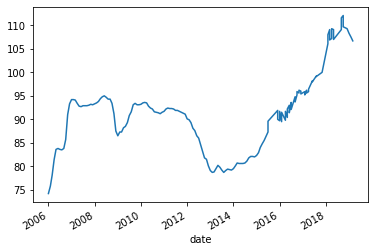

In [25]:
df['trade_price_idx_value'].plot()

## train 데이터, test 데이터 분리하기

이제 데이터를 train 데이터, test 데이터로 분리합니다. 2017년 1월 1일까지의 데이터를 train 데이터(blue line), 그 이후의 데이터를 test 데이터(yellow line)로 분리하도록 하겠습니다.

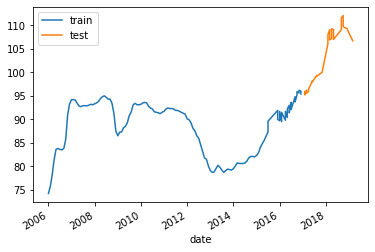

In [26]:
# pd.Timestamp를 이용하여 괄호 안의 날짜를 기준으로 df를 split합니다.
split_date = pd.Timestamp('01-01-2017')

train = df.loc[:split_date, ['trade_price_idx_value']]
test = df.loc[split_date:, ['trade_price_idx_value']]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

## 데이터 scaling

sklearn framework preprocessing 패키지의 MinMaxScaler 클래스를 사용하여 데이터를 스케일링 합니다. MinMaxScalar(X)는 데이터의 최대값이 1, 최소값이 0이 되도록 변환합니다. 이렇게 데이터의 scale을 맞추면 weight의 scale도 일관성 있게 나올 수 있습니다.

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train) # fit: model의 분포 계산 -> transform: 계산한 분포를 기준으로 data transform
test_scaled = scaler.transform(test) # transform 시 이용하는 min, max value,...등은 train data 기준으로 transform

print("train_scaled...")
print(train_scaled)
print("====="*10)
print("test_scaled...")
print(test_scaled)
print()
print("train_scaled data type: ", type(train_scaled))

train_scaled...
[[0.        ]
 [0.07272727]
 [0.17727273]
 [0.32727273]
 [0.42727273]
 [0.43636364]
 [0.42727273]
 [0.42272727]
 [0.43636364]
 [0.52272727]
 [0.76363636]
 [0.86818182]
 [0.90909091]
 [0.90909091]
 [0.90454545]
 [0.87272727]
 [0.84545455]
 [0.84090909]
 [0.85      ]
 [0.85      ]
 [0.85      ]
 [0.85454545]
 [0.86363636]
 [0.85909091]
 [0.86818182]
 [0.87727273]
 [0.89090909]
 [0.91818182]
 [0.93636364]
 [0.94545455]
 [0.93181818]
 [0.91363636]
 [0.91363636]
 [0.87272727]
 [0.77272727]
 [0.60454545]
 [0.55909091]
 [0.59545455]
 [0.59545455]
 [0.63636364]
 [0.65      ]
 [0.68636364]
 [0.75454545]
 [0.79090909]
 [0.85909091]
 [0.87272727]
 [0.85909091]
 [0.85909091]
 [0.86363636]
 [0.87727273]
 [0.88181818]
 [0.87727273]
 [0.84545455]
 [0.82727273]
 [0.81818182]
 [0.79090909]
 [0.78636364]
 [0.78181818]
 [0.77272727]
 [0.78636364]
 [0.79545455]
 [0.81818182]
 [0.82727273]
 [0.82272727]
 [0.82272727]
 [0.81818182]
 [0.80454545]
 [0.80454545]
 [0.79545455]
 [0.78636364]
 [0.

위에서 알 수 있듯이, train_scaled, test_scaled의 data type은 ndarray입니다. 하지만, scaling이 완료된 데이터들은 다시 pandas dataframe 데이터 타입으로 변환하는 것이 좋습니다. pandas는 시계열 자료에 대한 다양한 기능을 제공하여 LSTM에서 사용하는 window(추후 설명)를 만들기 유용하기 때문입니다.

In [28]:
train_scaled_df = pd.DataFrame(train_scaled, columns=['trade_price_idx_value'], index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=['trade_price_idx_value'], index=test.index)

train_scaled_df.head()

,trade_price_idx_value
date,
2006-01-01,0.000000
2006-02-01,0.072727
2006-03-01,0.177273
2006-04-01,0.327273
2006-05-01,0.427273


## sliding window 구성하기

window는 LSTM을 훈련하기 위한 단위로 고정된 사이즈를 가집니다. window가 12개라면 과거 시간 데이터 12개를 사용해서 다음 시간 단위의 값을 예측하게 됩니다. 현재 실험 데이터의 경우 과거의 시간 단위 12개 부동산 지수들이 훈련 속성들이 되고 현재 시간의 부동산 지수가 target이 됩니다. 쉽게 말하면, 이번 달의 부동산 지수를 예측하기 위해 제일 최근 과거 12개의 데이터를 이용하겠다는 것입니다.

dataframe의 shift 연산을 사용하면 인덱스는 그대로 두고 데이터만 시간 단위로 이동할 수 있어 sliding window 타입의 데이터를 구성하기에 용이합니다. 예를 들어 shift(1)을 하면 바로 다음 시간 인덱스로 데이터가 이동하며 shift(-1)을 하면 바로 이전 시간 인덱스로 데이터가 이동합니다. 아래 예시를 보면서 자세히 설명해보겠습니다.

In [29]:
# sliding window는 12로(12 moth = 1 year) 설정하였습니다.
sliding_window = 12
for i in range(1, 1+sliding_window):
    # shitf(i)를 하면 (해당 데이터의 index + i)의 index로 이동하여 데이터를 붙여넣습니다.
    train_scaled_df['shift_{}'.format(i)] = train_scaled_df['trade_price_idx_value'].shift(i)
    test_scaled_df['shift_{}'.format(i)] = test_scaled_df['trade_price_idx_value'].shift(i)

train_scaled_df.head(13)

,trade_price_idx_value,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,,
2006-01-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-01,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-01,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-01,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN,NaN
2006-09-01,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000,NaN,NaN,NaN,NaN


shift_1 칼럼을 살펴보면, 데이터 값이 다음 시간 인덱스로 한칸씩 이동한 것을 확인할 수 있습니다. 이렇게 구성된 데이터에서 dropna로 NaN값을 포함한 데이터를 제거하고 model에 주입할 것입니다.

## 데이터에서 NaN값 제거하기

이제 dropna 함수로 NaN 값을 제거하고 각각의 train 데이터와 test 데이터는 X(input)와 y(target) 열으로 분리합니다. 
drop함수는 특정 열이나 칼럼을 제거하는 기능을 합니다 

In [36]:
X_train = train_scaled_df.dropna().drop('trade_price_idx_value', axis=1) # axis=1은 열을 제거하겠다는 의미입니다.
y_train = train_scaled_df.dropna()[['trade_price_idx_value']]

### [문제5] test data에 대해서도 train data에서 했던 것처럼 dropna 함수로 NaN 값을 제거하고 drop 함수를 이용하여 X_test, y_test로 분리해주세요!

In [37]:
# [답변]
X_test = test_scaled_df.dropna().drop('trade_price_idx_value', axis=1) # axis=1은 열을 제거하겠다는 의미입니다.
y_test = test_scaled_df.dropna()[['trade_price_idx_value']]


In [38]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,
2007-01-01,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727,0.000000
2007-02-01,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273,0.072727
2007-03-01,0.909091,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273,0.177273
2007-04-01,0.904545,0.909091,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273,0.327273
2007-05-01,0.872727,0.904545,0.909091,0.909091,0.868182,0.763636,0.522727,0.436364,0.422727,0.427273,0.436364,0.427273


In [39]:
y_train.head()

,trade_price_idx_value
date,
2007-01-01,0.909091
2007-02-01,0.909091
2007-03-01,0.904545
2007-04-01,0.872727
2007-05-01,0.845455


## train / test 데이터 전처리 완료 확인

이제 model에 직접적으로 주입하기 위한 최종적인 data로 변형하기 위해, dataframe 타입이었던 train / test 데이터들을 values 를 사용하여 dataframe의 numpy 표현형만 가져옵니다. sklearn을 비롯한 기계학습 패키지들은 일반적으로 train / test 데이터로 numpy의 ndarray 타입을 지원합니다. values를 사용하기 전의 X_train은 DataFrame 타입이였지만 values를 사용한 후 numpy.ndarray로 변경된 것을 확인할 수 있습니다.

In [42]:
print("Before X_train type: ", type(X_train))
X_train = X_train.values
print("After X_train type: ", type(X_train))
print()
print("Before X_test type: ", type(X_test))
X_test= X_test.values
print("After X_test type: ", type(X_test))
print()
print("Before y_train type: ", type(y_train))
y_train = y_train.values
print("After y_train type: ", type(y_train))
print()
print("Before y_test type: ", type(y_test))
y_test = y_test.values
print("After y_test type: ", type(y_test))
print()
print("X_train.shape: ", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

Before X_train type:  <class 'pandas.core.frame.DataFrame'>
After X_train type:  <class 'numpy.ndarray'>

Before X_test type:  <class 'pandas.core.frame.DataFrame'>
After X_test type:  <class 'numpy.ndarray'>

Before y_train type:  <class 'pandas.core.frame.DataFrame'>
After y_train type:  <class 'numpy.ndarray'>

Before y_test type:  <class 'pandas.core.frame.DataFrame'>
After y_test type:  <class 'numpy.ndarray'>

X_train.shape:  (125, 12)
y_train.shape (125, 1)
X_test.shape:  (16, 12)
y_test.shape:  (16, 1)


훈련데이터 X_train은 125개의 데이터 개수와 12개의 slot을 가진것을 확인 할 수 있습니다. 훈련값 y_train은 역시 125개의 데이터 개수와 1개의 target 값을 가지고 있습니다. 

여기서 최종 train 데이터를 생성하기 위해서는 keras의 LSTM에서 필요로 하는 3차원 데이터로 변환을 시켜줘야 합니다. 즉, 최종 데이터의 shape이 (size, time step, feature) 형태로 나타나야 합니다. 이번 실험의 경우 속성이 아파트 지수 한가지 이기 때문에 1을 입력하지만 n 개의 속성을 사용할 경우 feature 순서에 n의 값을 입력하면 됩니다.

In [43]:
'''
size: X_train.shape[0]은 X_train data의 개수를 의미합니다. batch단위로 학습을 진행할 때는 batch_size로 설정해주면 됩니다.
time step: sliding window는 12로 설정했기 때문에 time step은 12로 설정해주어야합니다.
feature: input data의 dimension을 의미하는데, 현재는 아파트 지수로 dimension이 1이므로 1로 설정해주어야합니다.
'''

X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("preprocessed data")
print("X_train_t.shape: ", X_train_t.shape)
print()
print("X_train_t:")
print(X_train_t)
print()
print("y_train.shape: ", y_train.shape)
print()
print("y_train:")
print(y_train)

preprocessed data
X_train_t.shape:  (125, 12, 1)

X_train_t:
[[[0.86818182]
  [0.76363636]
  [0.52272727]
  ...
  [0.17727273]
  [0.07272727]
  [0.        ]]

 [[0.90909091]
  [0.86818182]
  [0.76363636]
  ...
  [0.32727273]
  [0.17727273]
  [0.07272727]]

 [[0.90909091]
  [0.90909091]
  [0.86818182]
  ...
  [0.42727273]
  [0.32727273]
  [0.17727273]]

 ...

 [[0.97272727]
  [0.98636364]
  [0.95454545]
  ...
  [0.81818182]
  [0.73636364]
  [0.79545455]]

 [[1.        ]
  [0.97272727]
  [0.98636364]
  ...
  [0.85454545]
  [0.81818182]
  [0.73636364]]

 [[0.99090909]
  [1.        ]
  [0.97272727]
  ...
  [0.78181818]
  [0.85454545]
  [0.81818182]]]

y_train.shape:  (125, 1)

y_train:
[[0.90909091]
 [0.90909091]
 [0.90454545]
 [0.87272727]
 [0.84545455]
 [0.84090909]
 [0.85      ]
 [0.85      ]
 [0.85      ]
 [0.85454545]
 [0.86363636]
 [0.85909091]
 [0.86818182]
 [0.87727273]
 [0.89090909]
 [0.91818182]
 [0.93636364]
 [0.94545455]
 [0.93181818]
 [0.91363636]
 [0.91363636]
 [0.87272727]
 

## LSTM model 생성하기 & Train



In [44]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K 

In [47]:
K.clear_session()

- 모델을 요약하자면 다음과 같습니다.

1.   `20 units (memory cell dimension)을 가진 LSTM layer`
2.   `Dense layer (output)`

12개의 과거 아파트 지수 데이터를 이용하여 그 다음 아파트 지수를 예측하는 모델을 생성할 것입니다. 

이를 위해 12개의 time step을 가지는 LSTM 레이어를 model에 추가합니다. 이 때 units는 20으로 설정했습니다. (ht, Ct, ...의 dimension) keras는 input이 어떤 shape으로 들어올지에 대한 정보가 필요하고 이를 알려주는 것이  input_shape 파라미터입니다. 이 때, data size는 중요하지 않으므로 (timestep, feature)의 튜플 형태로 입력해주면 됩니다. 

이어서, Dense 레이어 하나를 추가합니다. 마지막 LSTM cell의 output(hidden_state)에서 예측하고자 하는 target(그 다음 아파트 지수)의 개수가 하나이므로 Dense(1)을 출력으로 사용합니다.

###[문제6] 위 설명에 맞게 LSTM, Dense layer의 parameter를 지정해주세요!

In [48]:
model = Sequential() # Sequeatial Model 
model.add(LSTM(units=20, input_shape= (12, 1))) # input_shape: (timestep, feature) 
model.add(Dense(1)) # output_shape: 1

summary 메소드로 모델 구성 내용을 확인해봅시다.

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


### [문제7] 위의 model summary를 보시고, LSTM layer의 parameter수가 어떻게 해서 도출되었는지 설명해주세요.

- [답변]

compile에는 중요한 3가지 parameter가 있습니다.


*   optimizer : train optimizer를 설정합니다.
*   loss : optimization 과정에서 사용될 loss function을 설정합니다.
*   metrics : training을 모니터링하기 위해 사용됩니다.  

본 실습에서는 예측할 값이 연속된 값(regression)이므로 mean_squared_error를 loss 값으로 설정하고 optimizer는 adam을 이용합니다.

### [문제8] loss와 optimizer를 위에서 제시한 값으로 설정해주세요!

In [50]:
model.compile(loss='mse', optimizer='adam')

training 과정에서 한 번에 주입하는 데이터가 너무 많을 경우 전체 데이터를 메모리에 올리기 힘들 뿐만 아니라, 수렴하기 힘들다는 문제가 있습니다. 그렇기 때문에 큰 덩어리를 일정크기의 작은 덩어리로 잘라서 모델에 넣어서 학습시키는데, 이 작은 덩어리의 크기를 batch size라고 합니다. 본 실습에서는 batch_size=32로 설정하여 model을 training시키겠습니다. 또한, epochs를 100으로 하고, debug 정보는 출력하되 진행 정보만 확인할 수 있도록 verbose=1을 설정했습니다. 아래 cell을 실행시키면 training 결과 화면으로 epoch이 증가할때마다 loss값이 줄어드는 것을 확인할 수 있습니다.

In [51]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/100
4/4 [==============================] - 4s 8ms/step - loss: 0.4433
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.3616
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2838
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2139
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.1528
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1006
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0592
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0352
Epoch 9/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0297
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0345
Epoch 10: early stopping


## Test

evaluate 메소드를 사용하여 compile에서 사용했던 metric, mse 값이 얼마나 나오는지 확인해봅시다!

In [52]:
mse_loss = model.evaluate(X_test_t, y_test, batch_size=32)
print("Test MSE_loss: ", mse_loss)

1/1 [==============================] - 1s 519ms/step - loss: 0.1055
Test MSE_loss:  0.10553786158561707


## 결과 시각화

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

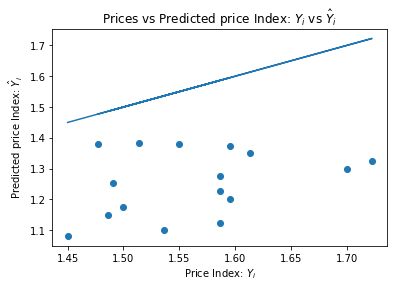

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_t, batch_size=32)
plt.plot(y_test, y_test)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")

원래 값과 예측 값이 일치하면 직선에 가깝게 분포가 되는데 결과는 그리 만족스럽지 않은 것 같습니다. 실제 강남 부동산 지수보다 예측 부동산 지수가 전반적으로 낮게 나오고 있습니다. 그 원인은 아마도 훈련 데이터 들이 대부분 부동산 침체기 시기 데이터를 사용 되었고 최근 데이터인 테스트 데이터는 훈련 데이터에는 없던 높은 지수가 많아서인 것으로 생각됩니다. 훈련 데이터를 최근 데이터까지 포함해서 좀더 범위를 높이면 성능은 좀 더 좋아질 것이라 생각됩니다.